# Soil-Water Retention ML Models
---

Tensorflow **version 2.12.0**

In [ ]:
!pip install tensorflow==2.12.0



---



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
base_path = 'drive/MyDrive/SE_132/Final_Project/'

# Project Descriptions:

In this project, various Machine Learning (ML) techniques are applied, including Polynomial regression, Ridge regression, K-nearest neighbors (KNN) regression, and Artifical Neural Networks (ANN), to predict the constitutive relationship between the degree of saturation (S), temperature (T), and matric suction ($\psi$) of MX80 bentonite soil.




- The inputs contains two features : **temperature** ($T$) in Degree Celsius and **suction** ($\psi$) in MPa. The targeted output is the **degree of saturation** ($S$). Therefore, the provided input temperature and suction are used to predict the degree of saturation. Note that the **output degree of saturation** should be in the range of 0% to 100%, or [0, 1].


- Note that because only **temperature** ($T$) and **suction** ($\psi$) are considered as input features, the predicted soil-water retention model is only applicable **to a specific type of soil sample (MX80 bentonite)**, which will be introduced later.



The ML models will be trained using the dataset generated from experimental data presented in [1] annd [2], and an existing generalized isothermal soil-water retention phenomenological equation. For each model, the following will be done:

- perform cross-validation to find the best set of parameters for each ML model
- calculate the mean-squared-error (MSE) of testing data
- plot the predicted soil-water retention curves (predicted degree of saturation vs. suction) at different temperature
- compare the testing MSEs of these ML models and discuss observations.

The **outline** of this Notebook is as follows:

1. Introduction and data preparation
    - Description of MX80 bentonite soil
    - Introduction of soil-water retention curve
    - Experimental data
2. Parametric Models
    - Polynomial regression
    - Ridge regression
3. Non-parametric Models
    - K-nearest neighbors (KNN) regression
    - Artifical neural networks (ANN) regression
4. Comparison and Discussion

# 1. Introduction and data preparation



## 1.1 Description of MX80 Bentonite Soil

MX80 Bentonite from Wyoming is one of the most popular types of bentonites used
internationally in bentonite buffer systems for nuclear waste storage. Because of large swelling of bentonite, it provides a tightly sealed, low-permeability barrier for nuclear waste container.

The MX80 bentonite sample we are investigating has a **dry density** of $\rho = 1.60 \text{ } g/cm^3$ and has a **specific gravity** of $G_s=2.76$.

### 1.1.1 Basic properties for soil

Soil mass is generally referred to as three-phase solid consisting **particles, liquid, and gas**. For many civil engineering applications, the liquid usually is considered to be **water** and the gas as **air**, as shown in the below figure.

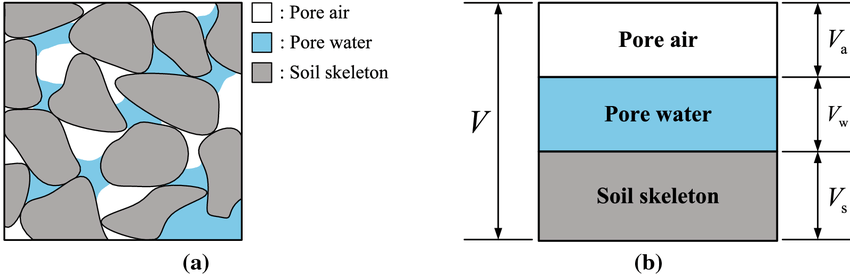

In [ ]:
from IPython.core.display import Image, display
display(Image(filename=base_path + 'images/SoilEquation.PNG',width=800))

There are some basic properties in soil mechanics:

- **Porosity**, n, the ratio of volume of voids ($V_a + V_w$) to the total volume:

$$ n=\frac{V_v}{V} = \frac{V_a + V_w}{V} \tag{1}$$

- **Volumetric water content**, $\theta$:

$$ \theta=\frac{V_w}{V} \tag{2}$$

- **Degree of saturation**, S, the ratio of volume of water to the volume of voids:

$$ S = \frac{V_w}{V_v} = \frac{\theta}{n} \tag{3}$$

- **Matric suction**, $\psi$:

$$ \psi = p_a-p_w \tag{4}$$
where $p_a$ and $p_w$ are the pore-air and pore-water pressure. $p_a$ is conventionally referenced as zero, so the suction is typically treated as the negative of water pressure.

## 1.2 What is a soil-water retention curve?

The soil-water retention curve (SWRC) is a vital relationship that describes unsaturated soil behaviors. The soil-water retention curve establishes a **relationship between water content** (commonly represented by volumetric water content $\theta$ or saturation $S$) **and matric suction** $\psi$ (i.e., the difference between the pore air pressure and pore water pressure).

The soil-water retention curve is typically estimated using **parameterized models** in the literature, which are also referred as **phenomenological models**. Various isothermal (not varying in temperture) parametric models have been proposed in the literature, including the Brooks and Corey (BC) model [4], van Genuchten (VG) model [5], and Fredlund and Xing (FX) model [6]. Several factors, such as the pore size distribution, porosity, pore fluid chemical composition, temperature, and soil mineralogy affect the soil-water retention behavior, resulting in **parametric models with multiple fitting parameters**.

For example, more recently Lu proposed a generalized soil-water retention curve in [3], which described relationship between suction and degree of saturation with fixed temperature (isothermal). However, Lu's model is not generalizable to varying temperature (non-isothermal) conditions.

The typical phenomenological soil-water retention curves at different temperatures look as follows:

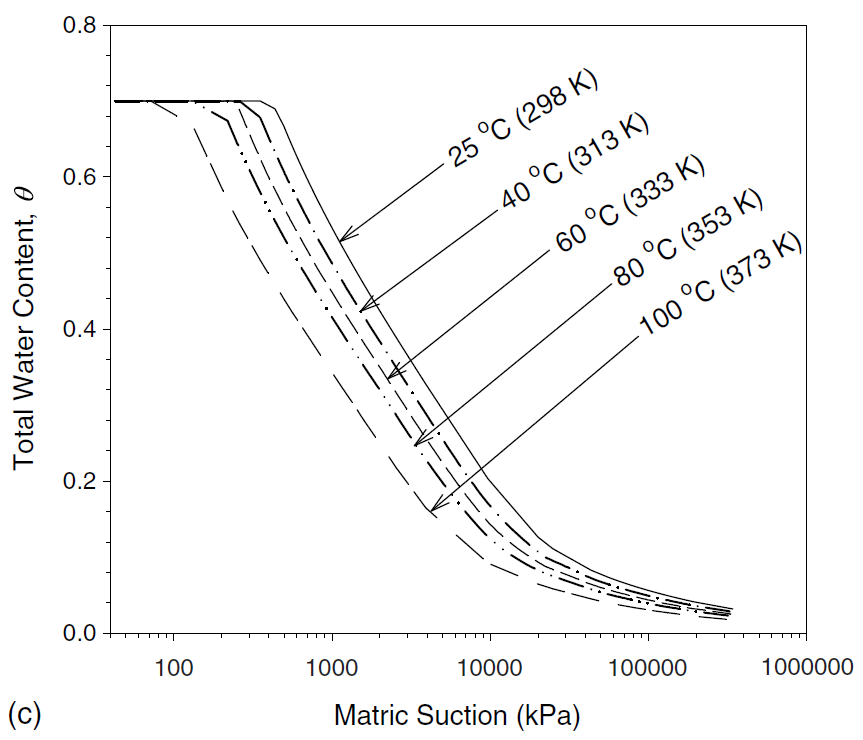

In [ ]:
display(Image(filename=base_path + 'images/TypicalSWRC.PNG',width=500))

In the above figure, each curve represents the relationship between **suction** and volumetric water content (related to **degree of saturation**, see Eq. (3)) at **a specific temperature**. As you can see, when the temperature gets higher, the curve is shifting towards the left.

In this project, we will use Machine Learning methods to obtain a **non-isothermal** soil-water retention curve. As a comparison, we will first explore polynomial regression models and make a comparison to the non-parametric KNN and ANN models.

## 1.3 Experimental Data


In order for machine learning algorithms to learn the soil-water retention behaviors, we need sufficient training data. The provided data in the `Data.csv` file are prepared by combining the experimental data from [1] and [2], as shown below, and fitting Lu's model [3] for specific temperatures.

**Import relative libraries and modules**

In [ ]:
### import libraries and modules
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, validation_curve
from sklearn.metrics import mean_squared_error
from time import time
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor

from platform import python_version
print('Python version: ', python_version())

import sklearn
print('Sklearn version: ', sklearn.__version__)

import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

from tensorflow import keras
print('Keras version: ', keras.__version__)

from sklearn.model_selection import RandomizedSearchCV

Python version:  3.10.12
Sklearn version:  1.2.2
Tensorflow version:  2.12.0
Keras version:  2.12.0


**Read and show data**

In [ ]:
### read the data and view the first 10 rows of data points (using Data.csv)
df = pd.read_csv(base_path + 'data/Data.csv')
df.head(10)

,Temperature,Suction,S
0,66.250000,58.144358,0.494224
1,65.000000,74.017600,0.419195
2,23.981367,113.768306,0.267319
3,70.008809,48.200936,0.529120
4,30.750000,120.184265,0.228080
5,60.054985,92.636198,0.332869
6,79.976239,28.090927,0.587149
7,42.250000,37.908815,0.569389
8,99.905452,44.817030,0.494816
9,79.986763,25.151843,0.601671


In [ ]:
df = df.to_numpy() # convert Dataframe to Numpy array
print('Shape of Dataframe: ', df.shape)
n_samples = df.shape[0]   # number of samples
print('Number of samples: ', n_samples)

Shape of Dataframe:  (2671, 3)
Number of samples:  2671


**Define the inputs and output, then split the data into training and testing**

In [ ]:
### inputs contains two features, which are the first two columns in the dataframe
### scaler output, which is the last column in the dataframe
### split the data into 30% for testing, set the random_state to be 1

x0 = df[:,0:2] # input features: temperature and suction
y0 = df[:,2] # output: degree of saturation (S)
test_size = 0.3            # 30% for testing set

x_train, x_test, y_train, y_test = train_test_split(x0,y0,test_size=test_size,random_state=1)

**Visualization of the dataset**

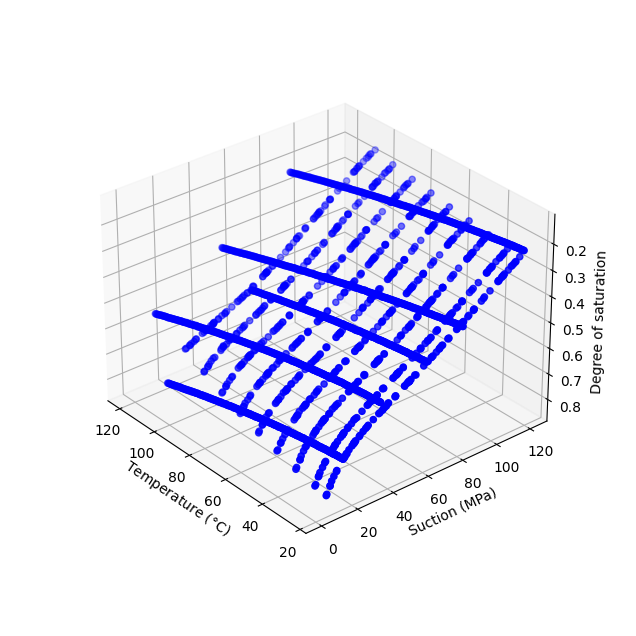

In [ ]:
plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(x0[:,[0]], x0[:,[1]], y0, c = 'b', marker='o')
ax.set_xlabel('Temperature ($\degree$C)')
ax.set_ylabel('Suction (MPa)')
ax.set_zlabel('Degree of saturation')
plt.grid()
ax.set_box_aspect(aspect=None, zoom=0.8)
ax.view_init(-150, 40)

As shown in the above visualization, the provided data represents a surface in 3D, and each pair of input (temperature, suction) corresponds to a output degree of saturation.

The ranges of provided data are:
- Temperature, $T \in [24, 120]$ degree celcius
- Suction, $\psi \in [0.234, 121.335]$ MPa
- output degree of saturation, $S \in [0.139, 0.835]$

**Standardize both inputs and output to reduce variance and bias in data**

In [ ]:
### standardize data

scalerX = StandardScaler()
scalerY = StandardScaler()

## fit
scalerX.fit(x_train)
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
scalerY.fit(y_train)

## transform
x_train_s = scalerX.transform(x_train)
y_train_s = scalerY.transform(y_train)

x_test_s = scalerX.transform(x_test)
y_test_s = scalerY.transform(y_test)

# 2. Parametric Models
- Polynomial regression
- Ridge regression

## 2.1 Polynomial Regression

**Model descriptions:**

A set of **input** temperature $ \{ T^{(i)}\}_{i=1}^m$ and suction $ \{ \psi^{(i)}\}_{i=1}^m$ data pairs with corresponding **targeted output** degree of saturation $ \{ S^{(i)}\}_{i=1}^m$ are provided. After we apply **polynomial feature transformation**, the given dataset can be expressed as:

$$ \{ \mathbf{x}^{(i)}, S^{(i)} \}_{i=1}^m $$

where $ \mathbf{x}^{(i)}$ is a vector of expanded input features and $ \mathbf{x}^{(i)} = [1, T^{(i)}, \psi^{(i)}, T^{(i)}\psi^{(i)}, ..., (T^{(i)})^d, (\psi^{(i)})^d]^T $ with $ d $ denoting the polynomial order.

Then we can apply multi-feature linear regression to predict the degree of saturation $S$, denoted as $\hat{S} \approx S$, and the prediction for $\mathbf{x}^{(i)}$ can be expressed in the following form:

$$ \hat{S}(\mathbf{x}^{(i)}) = (\mathbf{x}^{(i)})^T \hat{\boldsymbol{\theta}} = \hat{\theta}_0 + \hat{\theta}_1 T^{(i)} + \hat{\theta}_2 \psi^{(i)} + ... + \hat{\theta}_p (\psi^{(i)})^d \tag{5}$$

The optimal coefficients $\hat{\boldsymbol{\theta}} = [\hat{\theta}_0, \hat{\theta}_1, ..., , \hat{\theta}_p]^T $, with $p$ represents the total number of expanded features, can be obtained by minimizing the mean squared errors
$$J(\boldsymbol{\hat{\theta}}) = \frac{1}{m} \sum_{i=1}^m (\hat{S}(\mathbf{x}^{(i)}) - S^{(i)})^2 \tag{6}$$



---



**NOTE**: For example, for a two-feature input [a,b], the 'PolynomialFeature' with a degree $d = 2$ without bias would return $[a, b, a^2, ab, b^2]$, which means that with by a second order polynomial transformation, the number of features ($p$) expand from 2 for the first order polynomial to 5 for the second order polynomial.



---



**We are going to perform the following procedures in this section:**
- Use `validation_curve` for cross-validation to obtain the optimal degree for polynomial regression
- Train the best estimator from the grid search result
- Calculate the testing MSE
- Plot the `degree of saturation` vs. `suction` curves (predicted SWRC) at two temperatures

### Step 1:  Create Pipeline

In [ ]:
degree_range = np.arange(1, 21) # given a range of degrees [1,20] for cross-validation analysis in order to find the best flexibility

### create pipeline
poly_model = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression())
poly_model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'polynomialfeatures', 'linearregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'polynomialfeatures__order', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__positive'])

### Step 2: Perform 5-fold cross validation using the `validation_curve` from Scikit

In [ ]:
### the parameter to cross-validate is the "degrees" in the pipeline step "polynomialfeatures"

k_fold = 5
train_scores, CV_validation_scores = validation_curve(
                    poly_model, x0, y0, scoring='neg_mean_squared_error', cv=k_fold,
                    param_name='polynomialfeatures__degree',
                    param_range=degree_range)

print(CV_validation_scores.shape)# (n_degrees,n_folds)

(20, 5)


### Step 3: Plot training and validation MSE scores vs. polynomial orders calculated in previous step

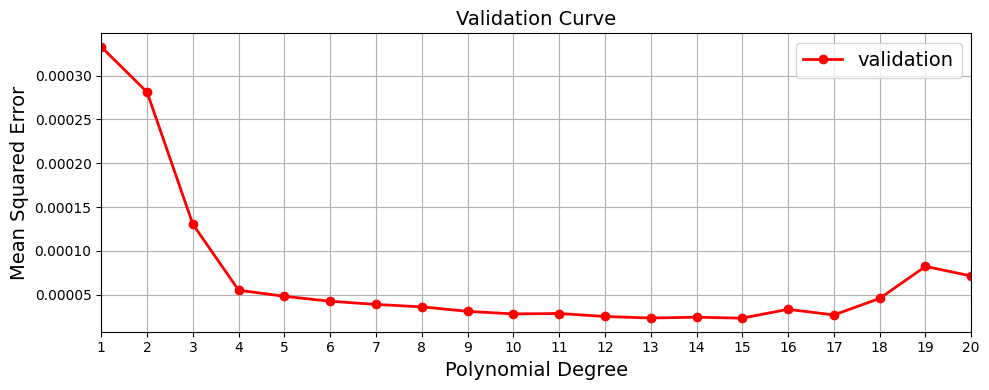

In [ ]:
### plot of the MSEs of training data and validation folds versus polynomial degrees
plt.figure(figsize=(10, 4))
plt.plot(degree_range, -CV_validation_scores.mean(axis=1), 'ro-', lw=2, label='validation')
plt.xlabel('Polynomial Degree', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.title('Validation Curve', fontsize=14)
plt.legend(fontsize=14)
plt.xlim(degree_range[0], degree_range[-1])
plt.xticks(degree_range)
plt.grid()
plt.tight_layout()

### Step 4: Find the degree with the lowest Validation MSE

In [ ]:
# find the degree that yields the minimum validation MSE. Store it in a list called 'degree_min'
degree_min = degree_range[-CV_validation_scores.mean(axis=1) == min(-CV_validation_scores.mean(axis=1))]
print(degree_min)

[15]


### Step 5: Create model with selected degree and find test MSE
Use pipeline and set the optimal degree found in the previous step as input to the variable `degree` in the transformation method `PolynomialFeatures`, and report the training time.

In [ ]:
### create a polynomial regression using the optimal degree found in the previous step
reg_model = make_pipeline(PolynomialFeatures(degree=degree_min[0]), LinearRegression())
start = time()
### f the instantiated model
reg_model.fit(x_train_s, y_train_s)

stop = time()

# print time
print('training time: {:.8f} s'.format(stop-start))

### print the optimal coefficients
print('Intercept: ', reg_model.steps[1][1].intercept_)
coefficients = reg_model.steps[1][1].coef_
print('# of Coefficients: ', coefficients.size)
print('Coefficients:')
print(coefficients)


### store predictions of training and testing data to the 'y_train_predict' and 'y_test_predict' variables
y_train_predict = reg_model.predict(x_train_s)
y_test_predict = reg_model.predict(x_test_s)

### calculate testing MSE for training/testing data
poly_mse_train = mean_squared_error(y_train_predict, y_train_s)
poly_mse_test = mean_squared_error(y_test_predict, y_test_s)

print("The MSE for polynomial regression using training and testing data are ", poly_mse_train, poly_mse_test)

training time: 0.04103780 s
Intercept:  [0.0901168]
# of Coefficients:  136
Coefficients:
[[ 7.10414907e-10 -2.49906473e-01 -1.08285930e+00 -2.20972527e-02
   2.65496657e-02  4.24360654e-01  2.87837687e-01  2.81431345e-03
  -4.52762999e-01  7.34629473e-01 -1.86828998e-01  2.58056035e-01
  -1.22576793e-01 -1.39466182e+00 -4.42930365e+00 -1.02045227e+00
  -8.16333948e-01  3.91949254e-01  2.09373020e+00  2.65926935e+00
   2.63705334e-01  4.13374787e-01 -6.78061745e-01 -9.93167617e-01
  -4.80905730e-01  1.77785648e+00  4.63509960e+00  1.00869840e+01
   1.49469785e+00  2.06134321e+00  4.57525823e-01 -2.12786301e+00
  -2.60676371e+00 -5.27628282e+00 -5.64934512e+00 -3.38332358e+00
  -4.56518096e-01  2.44275123e-01  1.74166690e+00  2.51992099e+00
   4.70737464e-01 -1.18248808e+00 -3.49055024e+00 -5.45300988e+00
  -1.01936564e+01 -1.03420956e+00 -2.11648816e+00 -7.28941999e-01
   1.87263953e+00  8.65440172e-01  2.40927421e+00  3.93161554e+00
   6.12524201e+00  5.48542251e+00  4.43123313e+00  2

### Step 6: Plot the predicted soil-water retention curve
- We are going to plot the soil-water retention curve for temperature at 30 and 100 degrees
- For each temperature, we plot the **degree of saturation** vs. **log10 of suction**.

Text(0.5, 1.0, 'Soil-Water Retention Curve')

<Figure size 640x480 with 0 Axes>

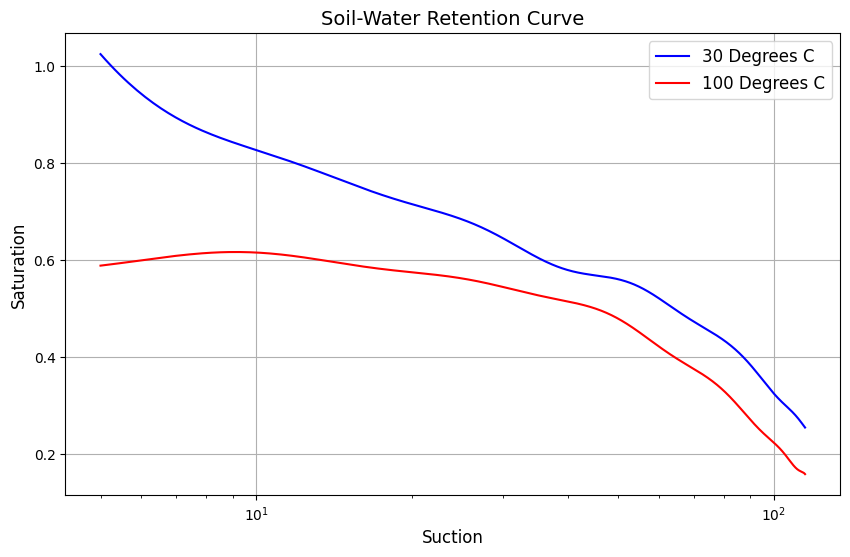

In [ ]:
# generate 1000 suction points for plotting purposes
suc_plot = np.linspace(5, 115, 1000).reshape(1000,1) # create 1000 uniformly sampled suction data within range [5,115]
temp_plot1 = np.ones((1000,1))*30 # create a vector of 1000 data with each element as 30 degree
temp_plot2 = np.ones((1000,1))*100 # create a vector of 1000 data with each element as 100 degree

### from the above generated temperature and suction data points, construct the inputs for prediction
X_test_30 = np.hstack((temp_plot1, suc_plot))
X_test_100 = np.hstack((temp_plot2, suc_plot))

X_test_30_scaled = scalerX.transform(X_test_30)
X_test_100_scaled = scalerX.transform(X_test_100)

### make prediction on X_test_30 and X_test_100, inverse transform predictions to the original scales
y_30_predict_scaled = reg_model.predict(X_test_30_scaled)
y_30_predict = scalerY.inverse_transform(y_30_predict_scaled.reshape(-1,1)).flatten()

y_100_predict_scaled = reg_model.predict(X_test_100_scaled)
y_100_predict = scalerY.inverse_transform(y_100_predict_scaled.reshape(-1,1)).flatten()

### plot the predicted soil-water retention curve in one figure
plt.clf()
plt.figure(figsize=(10, 6))
plt.semilogx(suc_plot, y_30_predict, 'b-', label="30 Degrees C")
plt.semilogx(suc_plot, y_100_predict, 'r-', label="100 Degrees C")
plt.grid()
plt.legend(fontsize=12)
plt.xlabel('Suction', fontsize=12)
plt.ylabel('Saturation', fontsize=12)
plt.title('Soil-Water Retention Curve', fontsize=14)

## 2.2 Ridge Regression

Ridge regression is a type of regularization method that adds an additional __shrinkage penalty term__ to the loss function in Eq. (6) to shrink the coefficients $\hat{\theta}_i$ towards 0. The tuning parameter $\lambda$ is usually determined by **cross-validation**.

**We are going to perform the following procedures in this section:**

- Use `GridSearchCV` for cross-validation to obtain the optimal value of parameter $\lambda$ and the degree of polynomial regression.
- Train the best estimator from the grid search result
- Calculate the testing MSE
- Plot the `degree of saturation` vs. `suction` curves (predicted SWRC) at two temperatures

### Step 1: Create a pipeline  to transform using `PolynomialFeatures` and fit using `linear_model.Ridge`.
Set `max_iter=10000` For `linear_model.Ridge`.

In [ ]:
kfold = 5
lambda_range = np.logspace(-4,4,9)
degree_range = np.arange(1,21)

###make a pipeline
ridge_poly_reg = make_pipeline(PolynomialFeatures(), Ridge(max_iter=10000))

# print out keys
ridge_poly_reg.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'polynomialfeatures', 'ridge', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'polynomialfeatures__order', 'ridge__alpha', 'ridge__copy_X', 'ridge__fit_intercept', 'ridge__max_iter', 'ridge__positive', 'ridge__random_state', 'ridge__solver', 'ridge__tol'])

### Step 2: Create a `GridSearchCV` object to fnd the optimal degree and $\lambda$

Create a list of parameters to be cross-validated and set `scoring = 'neg_mean_squared_error'` in the grid search.

In [ ]:
# create a parameter grid
param_grid = [{'polynomialfeatures__degree': degree_range,
               'ridge__alpha': lambda_range}]

# initialize the GridSearchCV
gs = GridSearchCV(estimator=ridge_poly_reg,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=kfold, n_jobs=-1,
                  return_train_score=True)

### Step 3: Fit the Grid Search object in the previous step on the training data and print the best parameters

In [ ]:
# fit grid search
gs_result = gs.fit(x_train_s, y_train_s)

# print the best parameters from gridsearchCV
print(gs_result.best_params_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


{'polynomialfeatures__degree': 17, 'ridge__alpha': 0.001}


### Step 4: Train the best estimator from the Grid Search result and calculate the testing MSE

In [ ]:
Ridge_poly_reg = gs_result.best_estimator_

# fit the model
Ridge_poly_reg.fit(x_train_s, y_train_s)

# store predictions of testing data to the 'y_test_predict' variable
y_test_predict = Ridge_poly_reg.predict(x_test_s)

# calculate and print the testing MSE
ridge_poly_reg_mse = mean_squared_error(y_test_predict, y_test_s)
print("The test MSE for Ridge regression is ", ridge_poly_reg_mse)

The test MSE for Ridge regression is  0.0008516054873932597


### Step 5: Plot the soil-water retention curve
- Again, for 30 and 100 degrees

<ipython-input-22-89b586f1a276>:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(suc_plot, y_30_predict, 'b-', linestyle='dashed', label="PolyReg: 30 Degrees C")
<ipython-input-22-89b586f1a276>:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(suc_plot, y_100_predict, 'r-', linestyle='dashed', label="PolyReg: 100 Degrees C")
<ipython-input-22-89b586f1a276>:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(suc_plot, Ridge_predict_30, 'b-', linestyle='solid', label="RidgeReg: 30 Degrees C")
<ipython-input-22-89b586f1a276>:14: UserWarning: linestyle is redundantly defined by the 'l

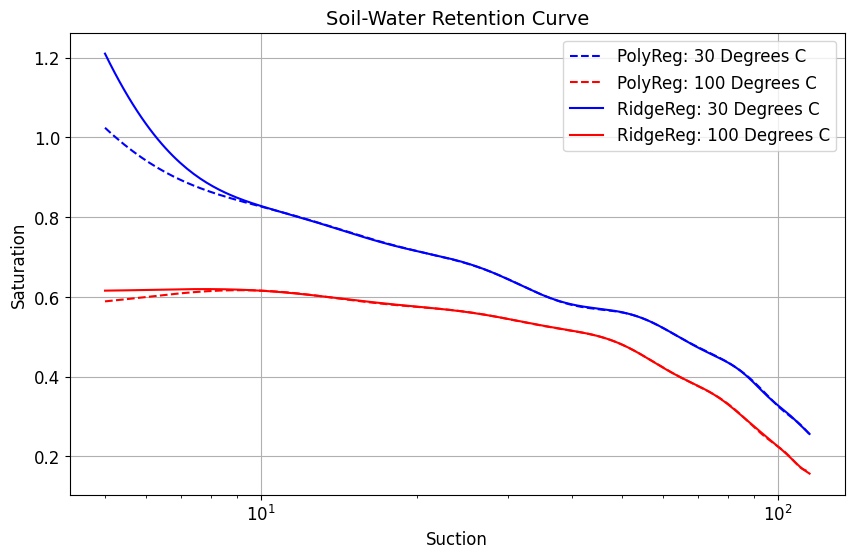

In [ ]:
Ridge_predict_30_scaled = Ridge_poly_reg.predict(X_test_30_scaled)
Ridge_predict_30 = scalerY.inverse_transform(Ridge_predict_30_scaled.reshape(-1,1)).flatten()

Ridge_predict_100_scaled = Ridge_poly_reg.predict(X_test_100_scaled)
Ridge_predict_100 = scalerY.inverse_transform(Ridge_predict_100_scaled.reshape(-1,1)).flatten()

### plot soil-water retention curve using both polynomial regression and Ridge regression
plt.figure(figsize=(10, 6))
plt.semilogx(suc_plot, y_30_predict, 'b-', linestyle='dashed', label="PolyReg: 30 Degrees C")
plt.semilogx(suc_plot, y_100_predict, 'r-', linestyle='dashed', label="PolyReg: 100 Degrees C")
plt.semilogx(suc_plot, Ridge_predict_30, 'b-', linestyle='solid', label="RidgeReg: 30 Degrees C")
plt.semilogx(suc_plot, Ridge_predict_100, 'r-', linestyle='solid', label="RidgeReg: 100 Degrees C")
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.legend(fontsize=12)
plt.xlabel('Suction', fontsize=12)
plt.ylabel('Saturation', fontsize=12)
plt.title('Soil-Water Retention Curve', fontsize=14)
plt.grid()

# 3. Non-parametric Models
- K-nearest neighbours (KNN) regression
- Artificial Neural Networks (ANN) regression

## 3.1 K-nearest neighbours (KNN) Regression


Given the number of neighbors $k$ and a input data $\mathbf{x} = (T, \psi)$, KNN regression first identifies $k$ nearest neighbors closest to $\mathbf{x}$, with their indices denoted by $\mathcal{N}(\mathbf{x})$, and then estimates $S(\mathbf{x})$ using the **average** of all the responses of the $k$ nearest neighbors, $\{S_i\}_{i \in \mathcal{N}(\mathbf{x})}$.

$$ \hat{S}(x) = \frac{1}{k} \sum_{i \in \mathcal{N}(x)} S_i \tag{7}$$

**NOTE**: The input points $\mathbf{x}$ are two-dimensional data points, corresponding to two input features.

**We are going to perform the following procedures in this section:**
- Use `GridSearchCV` for cross-validation to obtain the optimal number of nearest neighbors $k$
- Train the best estimator from the grid search result
- Calculate the testing MSE
- Plot the `degree of saturation` vs. `suction` curves (predicted SWRC) at two temperatures

### Step 1: Print out the keys that are available in the `knn_reg` pipeline object

In [ ]:
kfold = 5
k_range = np.arange(1,16) # search for the number of neighbors in range of [1,15]

### create a pipeline
knn_reg = make_pipeline(neighbors.KNeighborsRegressor())

knn_reg.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'kneighborsregressor', 'kneighborsregressor__algorithm', 'kneighborsregressor__leaf_size', 'kneighborsregressor__metric', 'kneighborsregressor__metric_params', 'kneighborsregressor__n_jobs', 'kneighborsregressor__n_neighbors', 'kneighborsregressor__p', 'kneighborsregressor__weights'])

### Step 2: Create a `GridSearchCV` object to fnd the optimal $k$

Create a list of parameters to be cross-validated and set `scoring = 'neg_mean_squared_error'` in the grid search.

In [ ]:
param_grid = [{'kneighborsregressor__n_neighbors': k_range}]

gs = GridSearchCV(estimator=knn_reg,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=kfold, n_jobs=-1,
                  return_train_score=True)

### Step 3: Fit the Grid Search object in the previous step on the training data and print the best parameters

In [ ]:
## fit the model
gs_result = gs.fit(x_train_s, y_train_s)
# KNN is very sensitive to scaling of data, so using scaled training data for fit.

print(gs_result.best_params_)

{'kneighborsregressor__n_neighbors': 1}


### Step 4: Train the best estimator from the Grid Search result and calculate the testing MSE

In [ ]:
knn_reg = gs_result.best_estimator_

## fit model
knn_reg.fit(x_train_s, y_train_s)

# store predictions of testing data to the 'y_test_predict' variable
y_test_predict = knn_reg.predict(x_test_s)

# calculate and print the testing MSE
knn_reg_mse = mean_squared_error(y_test_predict, y_test_s)

print("The test MSE for KNN regression is ", knn_reg_mse)

The test MSE for KNN regression is  0.0005252174023360511


### Step 5: Plot the soil-water retention curve
- Again, two curves, for 30 and 100 degrees

<ipython-input-27-f357bd11bee0>:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(suc_plot, y_30_predict, 'b-', linestyle='dashed', label="PolyReg: 30 Degrees C")
<ipython-input-27-f357bd11bee0>:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(suc_plot, y_100_predict, 'r-', linestyle='dashed', label="PolyReg: 100 Degrees C")
<ipython-input-27-f357bd11bee0>:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(suc_plot, knn_predict_30, 'b-', linestyle='solid', label="KNNReg: 30 Degrees C")
<ipython-input-27-f357bd11bee0>:14: UserWarning: linestyle is redundantly defined by the 'lines

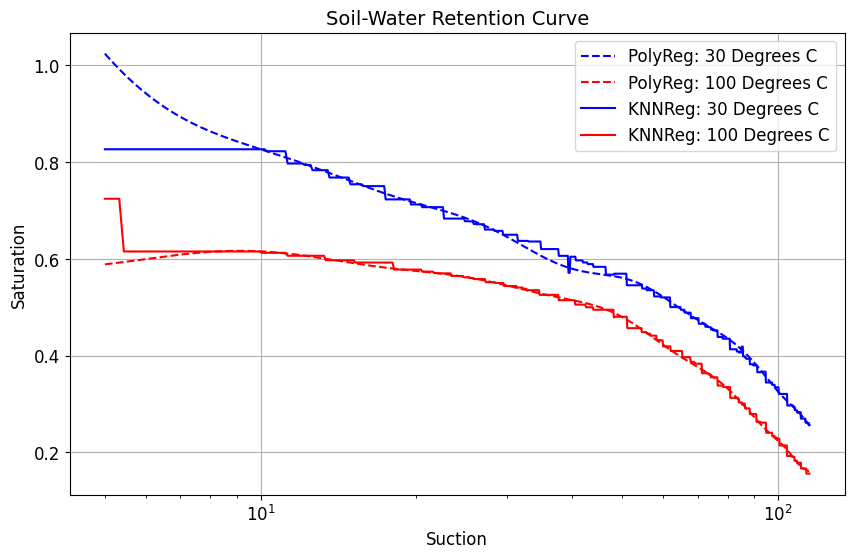

In [ ]:
knn_predict_30_scaled = knn_reg.predict(X_test_30_scaled)
knn_predict_30 = scalerY.inverse_transform(knn_predict_30_scaled.reshape(-1,1)).flatten()

knn_predict_100_scaled = knn_reg.predict(X_test_100_scaled)
knn_predict_100 = scalerY.inverse_transform(knn_predict_100_scaled.reshape(-1,1)).flatten()
### plot the retention curves using polynomial regression and knn
plt.figure(figsize=(10, 6))
plt.semilogx(suc_plot, y_30_predict, 'b-', linestyle='dashed', label="PolyReg: 30 Degrees C")
plt.semilogx(suc_plot, y_100_predict, 'r-', linestyle='dashed', label="PolyReg: 100 Degrees C")
plt.semilogx(suc_plot, knn_predict_30, 'b-', linestyle='solid', label="KNNReg: 30 Degrees C")
plt.semilogx(suc_plot, knn_predict_100, 'r-', linestyle='solid', label="KNNReg: 100 Degrees C")
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.legend(fontsize=12)
plt.xlabel('Suction', fontsize=12)
plt.ylabel('Saturation', fontsize=12)
plt.title('Soil-Water Retention Curve', fontsize=14)
plt.grid()

## 3.2 Artificial Neural Networks (ANN)


The prediction of degree of saturation using ANN can be expressed as:

$$
\hat{S}=\mathcal{N}^{A N N}(T,\psi; \boldsymbol{\Theta}) \tag{8}
$$
where $\mathcal{N}^{A N N}$ represents the layer operations included in the ANN model, and $\boldsymbol{\Theta}$ is the group of all trainable weights and biases in the ANN model.

**We are going to perform the following procedures in this section:**
- Use `RandomizedSearchCV` to find the optimal values of following parameters:
    - Number of layers
    - Number of neurons in each layer
    - Learning rate
- Train the best estimator from the grid search result
- Calculate the testing MSE
- Plot the `degree of saturation` vs. `suction` curves (predicted SWRC) at two temperatures

### Step 1: Define a function for building Neural Network models

In [ ]:
# 1. define a nueral network model

### define a function for building neural network models
def build_model(n_hidden=8, n_neurons=60, learning_rate=3e-3, input_shape=[2]):

    ### initialize a sequential ann model
    model = keras.models.Sequential()

    ### efine the input layer
    model.add(keras.layers.InputLayer(input_shape=input_shape))

    ### define the hidden layers, using "tanh" activation function
    for layer in range(n_hidden):
      model.add(keras.layers.Dense(n_neurons, activation='tanh'))

    ### define the output layer, using "linear" activation function
    model.add(keras.layers.Dense(1))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [ ]:
# put the KerasRegressor wrapper around the defined NN model function
keras_reg =  keras.wrappers.scikit_learn.KerasRegressor(build_model)
keras_reg.get_params()

<ipython-input-29-45e9fe9738ab>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg =  keras.wrappers.scikit_learn.KerasRegressor(build_model)


{'build_fn': <function __main__.build_model(n_hidden=8, n_neurons=60, learning_rate=0.003, input_shape=[2])>}

### Step 2: Create a `RandomizedSearchCV` object

Set the ranges of the number of hidden layers, the number of neurons per layer, and the learning rates as $[1,5]$, $[10,100]$, and $[10^{-5},10^{-1}]$, respectively, and use `cv=5` and `n_iter=3` in `RandomizedSearchCV`.

In [ ]:
# generate a parameter space
param_distribs = {"n_hidden": np.arange(1,6).tolist(),
                  "n_neurons": np.arange(10,101).tolist(),
                  "learning_rate": np.logspace(-5, -1, num=10000)}

### define the RandomizedSearchCV (verbose = 2, n_jobds=-1, random_state=1)
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=3, cv=5, verbose=2, n_jobs=-1, random_state=1)

### Step 3: Fit the Grid Search object in the previous step on the training data and print the best parameters

In [ ]:
### grid search, each model is trained by 200 epochs
rnd_search_cv.fit(x_train_s, y_train_s, epochs=200)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Epoch 1/200
59/59 [==============================] - 1s 2ms/step - loss: 1.3737
Epoch 2/200
59/59 [==============================] - 0s 2ms/step - loss: 0.8797
Epoch 3/200
59/59 [==============================] - 0s 2ms/step - loss: 0.5189
Epoch 4/200
59/59 [==============================] - 0s 2ms/step - loss: 0.2703
Epoch 5/200
59/59 [==============================] - 0s 2ms/step - loss: 0.1248
Epoch 6/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0568
Epoch 7/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0328
Epoch 8/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0260
Epoch 9/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0245
Epoch 10/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 11/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0240
Epoch 12/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0239
Epoch 13/200
59/59 [=================

RandomizedSearchCV(cv=5,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x799858246320>,
                   n_iter=3, n_jobs=-1,
                   param_distributions={'learning_rate': array([1.00000000e-05, 1.00092155e-05, 1.00184395e-05, ...,
       9.98159444e-02, 9.99079298e-02, 1.00000000e-01]),
                                        'n_hidden': [1, 2, 3, 4, 5],
                                        'n_neurons': [10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, 31, 32, 33,
                                                      34, 35, 36, 37, 38, 39, ...]},
                   random_state=1, verbose=2)

In [ ]:
### print out the best parameters
print(rnd_search_cv.best_params_)

{'n_neurons': 55, 'n_hidden': 4, 'learning_rate': 2.7017375839922856e-05}


### Step 4: Train the best estimator from the Grid Search result and calculate the testing MSE

In [ ]:
tf.random.set_seed(1)

### train the best estimator with 1000 epochs
ann_reg = rnd_search_cv.best_estimator_
## fit the model
ann_reg.fit(x_train_s, y_train_s, epochs=1000)

# store predictions of testing data to the 'y_test_predict' variable
y_test_predict = ann_reg.predict(x_test_s)

Epoch 1/1000
59/59 [==============================] - 2s 4ms/step - loss: 1.0734
Epoch 2/1000
59/59 [==============================] - 0s 3ms/step - loss: 0.6172
Epoch 3/1000
59/59 [==============================] - 0s 3ms/step - loss: 0.3218
Epoch 4/1000
59/59 [==============================] - 0s 3ms/step - loss: 0.1502
Epoch 5/1000
59/59 [==============================] - 0s 3ms/step - loss: 0.0685
Epoch 6/1000
59/59 [==============================] - 0s 4ms/step - loss: 0.0387
Epoch 7/1000
59/59 [==============================] - 0s 4ms/step - loss: 0.0309
Epoch 8/1000
59/59 [==============================] - 0s 3ms/step - loss: 0.0290
Epoch 9/1000
59/59 [==============================] - 0s 3ms/step - loss: 0.0286
Epoch 10/1000
59/59 [==============================] - 0s 3ms/step - loss: 0.0283
Epoch 11/1000
59/59 [==============================] - 0s 3ms/step - loss: 0.0280
Epoch 12/1000
59/59 [==============================] - 0s 3ms/step - loss: 0.0277
Epoch 13/1000
59/59 [====

In [ ]:
### calculate testing MSE and print its value
ann_reg_mse = mean_squared_error(y_test_predict, y_test_s)
print("The test MSE for ANN regression is ", ann_reg_mse)

The test MSE for ANN regression is  0.001400138781085615


### Step 5: Plot the soil-water retention curve
- For 30 and 100 degree C

32/32 [==============================] - 0s 4ms/step


<ipython-input-36-1da0c06ffe74>:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(suc_plot, y_30_predict, 'b-', linestyle='dashed', label="PolyReg: 30 Degrees C")
<ipython-input-36-1da0c06ffe74>:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(suc_plot, y_100_predict, 'r-', linestyle='dashed', label="PolyReg: 100 Degrees C")
<ipython-input-36-1da0c06ffe74>:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(suc_plot, nn_predict_30, 'b-', linestyle='solid', label="ANNReg: 30 Degrees C")
<ipython-input-36-1da0c06ffe74>:13: UserWarning: linestyle is redundantly defined by the 'linest

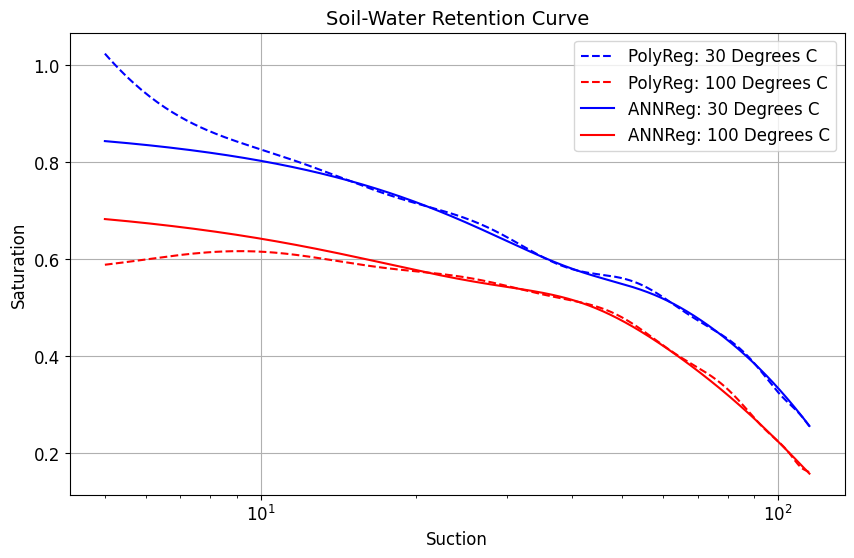

In [ ]:
nn_predict_30_scaled = ann_reg.predict(X_test_30_scaled)
nn_predict_30 = scalerY.inverse_transform(nn_predict_30_scaled.reshape(-1,1)).flatten()

nn_predict_100_scaled = ann_reg.predict(X_test_100_scaled)
nn_predict_100 = scalerY.inverse_transform(nn_predict_100_scaled.reshape(-1,1)).flatten()
### plot the retention curves using polynomial regression and ANN
plt.figure(figsize=(10, 6))
plt.semilogx(suc_plot, y_30_predict, 'b-', linestyle='dashed', label="PolyReg: 30 Degrees C")
plt.semilogx(suc_plot, y_100_predict, 'r-', linestyle='dashed', label="PolyReg: 100 Degrees C")
plt.semilogx(suc_plot, nn_predict_30, 'b-', linestyle='solid', label="ANNReg: 30 Degrees C")
plt.semilogx(suc_plot, nn_predict_100, 'r-', linestyle='solid', label="ANNReg: 100 Degrees C")
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.legend(fontsize=12)
plt.xlabel('Suction', fontsize=12)
plt.ylabel('Saturation', fontsize=12)
plt.title('Soil-Water Retention Curve', fontsize=14)
plt.grid()

## ANN with custom-designed loss function

**NOTE**: for the above models, we used the built-in mean squared error as the loss function when we compile the neural network model. Recall that the output degree of saturation should have a range of $[0,1]$. We can introduce a penalty term to constrain the NN predicted degrees of saturation such that $\hat{S} \in [0,1]$. However, this will require a **custom-designed loss function** for the neural network.

In [ ]:
y_std = scalerY.scale_
y_mean = scalerY.mean_

def build_model_custom(n_hidden=8, n_neurons=60, learning_rate=3e-3, input_shape=[2]):
    def custom_loss(y_true, y_pred):
      mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
      # no need for explicit regularization term as custom regularizer is used
      # transform y_pred back to original scale
      y_pred_original = y_pred * y_std + y_mean
      # penalize deviation from [0, 1] range using ReLU
      penalty = tf.reduce_mean(tf.nn.relu(y_pred_original - 1))
      return mse_loss + penalty

    model = keras.models.Sequential()

    # input layer
    model.add(keras.layers.InputLayer(input_shape=input_shape))

    # hidden layers
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="tanh"))

    # output layer, with only one output neuron
    model.add(keras.layers.Dense(1, activation="linear"))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=custom_loss)
    return model

Now, we are going to do the randomized grid search for the ANN model with additionally added constraint.

In [ ]:
### create a keras wrapper for 'build_model_custom' function
keras_reg_cus = keras.wrappers.scikit_learn.KerasRegressor(build_model_custom)
keras_reg_cus.get_params()

<ipython-input-40-9b6567ecde4e>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg_cus = keras.wrappers.scikit_learn.KerasRegressor(build_model_custom)


{'build_fn': <function __main__.build_model_custom(n_hidden=8, n_neurons=60, learning_rate=0.003, input_shape=[2])>}

In [ ]:
### define the parameter space, the same as the previous ANN model

param_distribs = {"n_hidden": np.arange(1,6).tolist(),
                  "n_neurons": np.arange(10,101).tolist(),
                  "learning_rate": np.logspace(-5, -1, num=10000)}

### define the RandomizedSearchCV with the same n_iter, cv, verbose, and random_state as for the previous ANN model
rnd_search_cv2 = RandomizedSearchCV(keras_reg_cus, param_distribs, n_iter=3, cv=5, verbose=2, n_jobs=-1, random_state=1)

In [ ]:
### fit the grid search, each model is trained by 200 epochs
rnd_search_cv2.fit(x_train_s, y_train_s, epochs=200)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Epoch 1/200
59/59 [==============================] - 4s 5ms/step - loss: 0.5275
Epoch 2/200
59/59 [==============================] - 0s 4ms/step - loss: 0.2236
Epoch 3/200
59/59 [==============================] - 0s 4ms/step - loss: 0.0832
Epoch 4/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0355
Epoch 5/200
59/59 [==============================] - 0s 4ms/step - loss: 0.0247
Epoch 6/200
59/59 [==============================] - 0s 4ms/step - loss: 0.0230
Epoch 7/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0227
Epoch 8/200
59/59 [==============================] - 0s 4ms/step - loss: 0.0225
Epoch 9/200
59/59 [==============================] - 0s 4ms/step - loss: 0.0223
Epoch 10/200
59/59 [==============================] - 0s 4ms/step - loss: 0.0222
Epoch 11/200
59/59 [==============================] - 0s 4ms/step - loss: 0.0220
Epoch 12/200
59/59 [==============================] - 0s 4ms/step - loss: 0.0218
Epoch 13/200
59/59 [=================

RandomizedSearchCV(cv=5,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x799847d94c70>,
                   n_iter=3, n_jobs=-1,
                   param_distributions={'learning_rate': array([1.00000000e-05, 1.00092155e-05, 1.00184395e-05, ...,
       9.98159444e-02, 9.99079298e-02, 1.00000000e-01]),
                                        'n_hidden': [1, 2, 3, 4, 5],
                                        'n_neurons': [10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, 31, 32, 33,
                                                      34, 35, 36, 37, 38, 39, ...]},
                   random_state=1, verbose=2)

In [ ]:
### print out the best parameters
print(rnd_search_cv2.best_params_)

{'n_neurons': 55, 'n_hidden': 4, 'learning_rate': 2.7017375839922856e-05}


In [ ]:
tf.random.set_seed(1)

### train the best estimator with 1000 epochs
ann_reg_cus = rnd_search_cv2.best_estimator_
## Fit (train) the model
ann_reg_cus.fit(x_train_s, y_train_s, epochs=1000)

Epoch 1/1000
59/59 [==============================] - 1s 2ms/step - loss: 0.4950
Epoch 2/1000
59/59 [==============================] - 0s 2ms/step - loss: 0.2710
Epoch 3/1000
59/59 [==============================] - 0s 2ms/step - loss: 0.1313
Epoch 4/1000
59/59 [==============================] - 0s 3ms/step - loss: 0.0591
Epoch 5/1000
59/59 [==============================] - 0s 2ms/step - loss: 0.0317
Epoch 6/1000
59/59 [==============================] - 0s 2ms/step - loss: 0.0244
Epoch 7/1000
59/59 [==============================] - 0s 4ms/step - loss: 0.0231
Epoch 8/1000
59/59 [==============================] - 0s 4ms/step - loss: 0.0228
Epoch 9/1000
59/59 [==============================] - 0s 3ms/step - loss: 0.0227
Epoch 10/1000
59/59 [==============================] - 0s 4ms/step - loss: 0.0225
Epoch 11/1000
59/59 [==============================] - 0s 4ms/step - loss: 0.0224
Epoch 12/1000
59/59 [==============================] - 0s 3ms/step - loss: 0.0223
Epoch 13/1000
59/59 [====

In [ ]:
### calculate testing MSE and print its value
y_test_predict = ann_reg_cus.predict(x_test_s)
ann_reg_cus_mse = mean_squared_error(y_test_predict, y_test_s)
print("The test MSE for ANN regression is ", ann_reg_cus_mse)

26/26 [==============================] - 0s 1ms/step
The test MSE for ANN regression is  0.0015187114145680076


32/32 [==============================] - 0s 2ms/step


<ipython-input-46-837efb7b281e>:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(suc_plot, y_30_predict, 'b-', linestyle='dashed', label="PolyReg: 30 Degrees C")
<ipython-input-46-837efb7b281e>:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(suc_plot, y_100_predict, 'r-', linestyle='dashed', label="PolyReg: 100 Degrees C")
<ipython-input-46-837efb7b281e>:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(suc_plot, nn2_predict_30, 'b-', linestyle='solid', label="CustomANNReg: 30 Degrees C")
<ipython-input-46-837efb7b281e>:14: UserWarning: linestyle is redundantly defined by the 

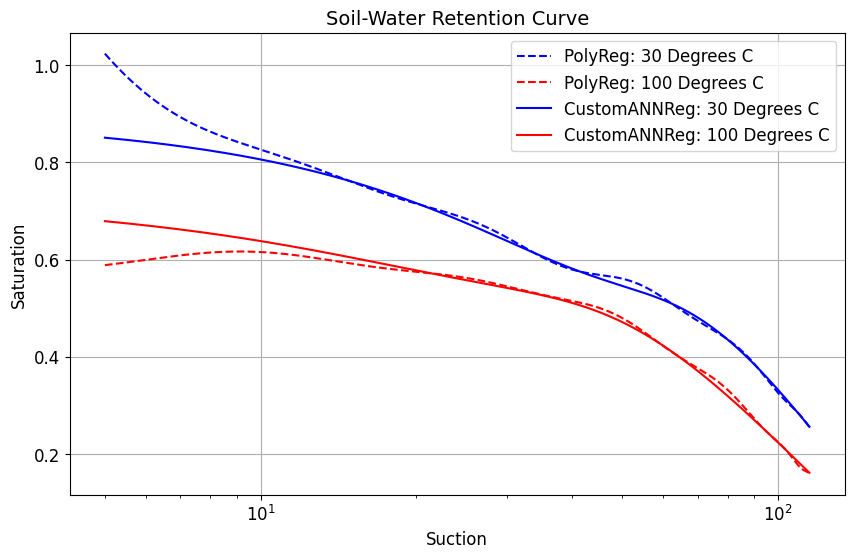

In [ ]:
nn2_predict_30_scaled = ann_reg_cus.predict(X_test_30_scaled)
nn2_predict_30 = scalerY.inverse_transform(nn2_predict_30_scaled.reshape(-1,1)).flatten()

nn2_predict_100_scaled = ann_reg_cus.predict(X_test_100_scaled)
nn2_predict_100 = scalerY.inverse_transform(nn2_predict_100_scaled.reshape(-1,1)).flatten()

### plot the retention curves for the prediction of two ann models
plt.figure(figsize=(10, 6))
plt.semilogx(suc_plot, y_30_predict, 'b-', linestyle='dashed', label="PolyReg: 30 Degrees C")
plt.semilogx(suc_plot, y_100_predict, 'r-', linestyle='dashed', label="PolyReg: 100 Degrees C")
plt.semilogx(suc_plot, nn2_predict_30, 'b-', linestyle='solid', label="CustomANNReg: 30 Degrees C")
plt.semilogx(suc_plot, nn2_predict_100, 'r-', linestyle='solid', label="CustomANNReg: 100 Degrees C")
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.legend(fontsize=12)
plt.xlabel('Suction', fontsize=12)
plt.ylabel('Saturation', fontsize=12)
plt.title('Soil-Water Retention Curve', fontsize=14)
plt.grid()

# 4. Comparison and Discussion

## 4.1 Comparison
Let's test the prediction performance of the previously trained models (polynomial regression, Ridge regression, KNN, built-in ANN, and ANN with an additional constraint) for some unseen data stored in 'NewData.csv'. Note that these additional (temperature, suction, degree of saturation) data are not included in the previous training or testing data. They are experimental data obtained from Figure. 5 in [1].


In [ ]:
### read the 'NewData.csv' into a dataframe and show the first 10 rows
df2 = pd.read_csv(base_path + 'data/NewData.csv')
df2.head(10)

,Temperature,Suction,S
0,41,81.620771,0.406546
1,41,63.776565,0.497044
2,41,38.221866,0.567179
3,41,16.081839,0.707450
4,101,59.921333,0.406869
5,101,47.254142,0.497044
6,101,22.140063,0.566856
7,101,2.863881,0.706804
8,26,86.145427,0.406974
9,26,65.457390,0.498493


In [ ]:
df2 = df2.to_numpy() # convert Dataframe to Numpy array
print('Shape of Dataframe: ', df2.shape)
n_predict2 = df2.shape[0]   # number of prediction points
print('Number of prediction points: ', n_predict2)

Shape of Dataframe:  (16, 3)
Number of prediction points:  16


In [ ]:
### define the input and output for prediction
x_predict = df2[:,0:2]
y_predict = df2[:,2].reshape(-1,1)

x_predict_s = scalerX.transform(x_predict)
y_predict_s = scalerY.transform(y_predict)

In [ ]:
## predictions and evaluate the MSE for each model

## 1. polynomial regression model
y_predict_predict1 = reg_model.predict(x_predict_s)
poly_mse_predict = mean_squared_error(y_predict_predict1, y_predict_s)
print('The MSE for the prediction of new data points using polynomial regression is: ', poly_mse_predict)

## 2. ridge regression model
y_predict_predict2 = Ridge_poly_reg.predict(x_predict_s)
Ridge_poly_mse_predict = mean_squared_error(y_predict_predict2, y_predict_s)
print('The MSE for the prediction of new data points using Ridge polynomial regression is: ', Ridge_poly_mse_predict)

## 3. KNN
y_predict_predict3 = knn_reg.predict(x_predict_s)
knn_mse_predict = mean_squared_error(y_predict_predict3, y_predict_s)
print('The MSE for the prediction of new data points using KNN is: ', knn_mse_predict)

## 4. ANN
y_predict_predict4 = ann_reg.predict(x_predict_s)
ann_mse_predict = mean_squared_error(y_predict_predict4, y_predict_s)
print('The MSE for the prediction of new data points using ANN is: ', ann_mse_predict)

## 5. ANN with constraint on the output
y_predict_predict5 = ann_reg_cus.predict(x_predict_s)
ann_cus_mse_predict = mean_squared_error(y_predict_predict5, y_predict_s)
print('The MSE for the prediction of new data points using ANN with penalty is: ', ann_cus_mse_predict)


The MSE for the prediction of new data points using polynomial regression is:  0.05991382716479861
The MSE for the prediction of new data points using Ridge polynomial regression is:  0.032187283194844304
The MSE for the prediction of new data points using KNN is:  0.003661713049401649
1/1 [==============================] - 0s 53ms/step
The MSE for the prediction of new data points using ANN is:  0.005693200292785317
1/1 [==============================] - 0s 32ms/step
The MSE for the prediction of new data points using ANN with penalty is:  0.006330910806571072


Now, let's compare the prediction of soil-water retention curve at 26 degree C using all the trained models.

32/32 [==============================] - 0s 3ms/step


<ipython-input-76-f4d9ec02e71a>:38: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(suc_plot, poly_theta_26, 'g-', linestyle='solid', label="PolyReg")
<ipython-input-76-f4d9ec02e71a>:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "y-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(suc_plot, Ridge_theta_26, 'y-', linestyle='solid', label="RidgeReg")
<ipython-input-76-f4d9ec02e71a>:40: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "m-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(suc_plot, KNN_theta_26, 'm-', linestyle='solid', label="KNNReg")
<ipython-input-76-f4d9ec02e71a>:41: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b

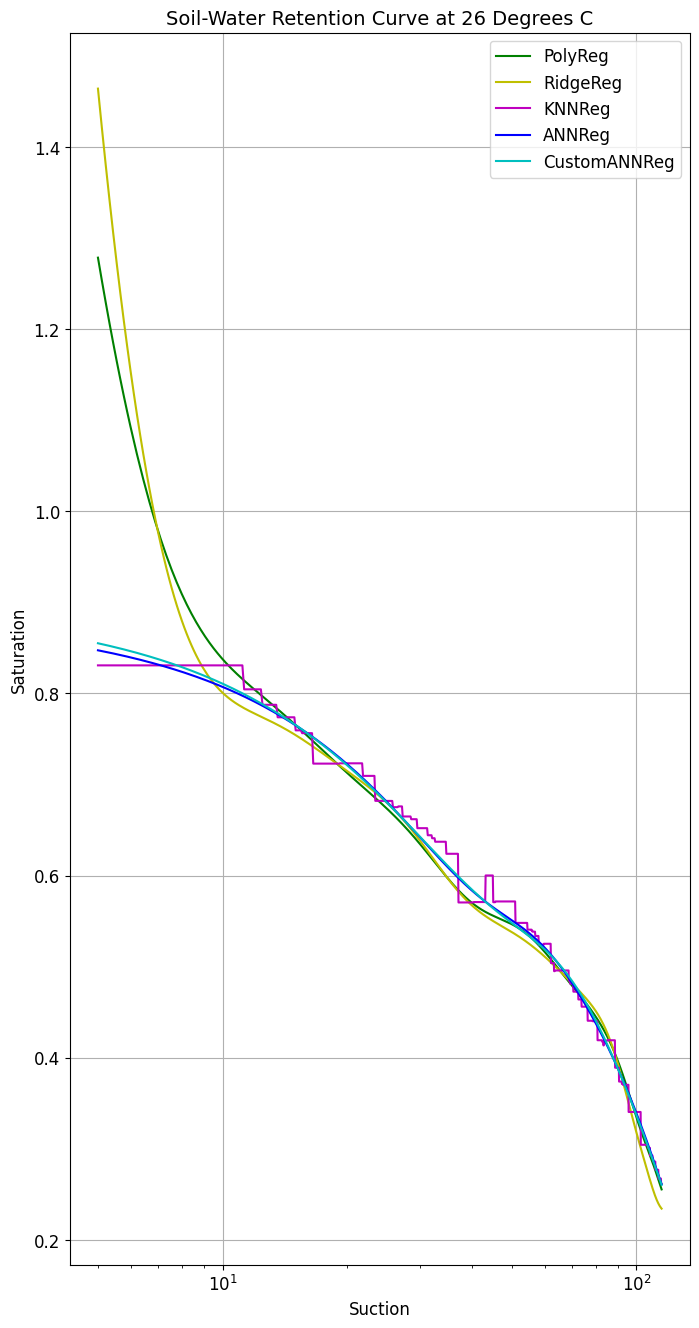

In [ ]:
# 1. Generate prediction points:
    # Generate 1000 uniformly sampled suction data within range [5,115] MPa
    # Generate 1000 temperature points that are all 26 degree C
    # Then combine the two and create a prediction data (standardized)
suc_plot = np.linspace(5, 115, 1000).reshape(1000,1)
temp_plot3 = np.ones((1000,1))*26 # create a vector of 1000 data with each element as 26 degree
## combine the temperature and suction data points
X_test_26 = np.hstack((temp_plot3, suc_plot))
X_test_26_scaled = scalerX.transform(X_test_26)


# 2. using the trained models to predict the degree of saturation, transform back to the original scale
# polynomial regression
poly_theta_26_scaled = reg_model.predict(X_test_26_scaled)
poly_theta_26 = scalerY.inverse_transform(poly_theta_26_scaled.reshape(-1,1)).flatten()

# ridge regression
Ridge_theta_26_scaled = Ridge_poly_reg.predict(X_test_26_scaled)
Ridge_theta_26 = scalerY.inverse_transform(Ridge_theta_26_scaled.reshape(-1,1)).flatten()

# KNN
KNN_theta_26_scaled = knn_reg.predict(X_test_26_scaled)
KNN_theta_26 = scalerY.inverse_transform(KNN_theta_26_scaled.reshape(-1,1)).flatten()

# ANN
ANN_theta_26_scaled = ann_reg.predict(X_test_26_scaled)
ANN_theta_26 = scalerY.inverse_transform(ANN_theta_26_scaled.reshape(-1,1)).flatten()

# ANN with constraint
ANN_cus_theta_26_scaled = ann_reg_cus.predict(X_test_26_scaled)
ANN_cus_theta_26 = scalerY.inverse_transform(ANN_cus_theta_26_scaled.reshape(-1,1)).flatten()


# 3. plot predicted degree of saturation vs. log10(suction) for all predictions in one figure
plt.figure(figsize=(8, 16))
#plt.semilogx(x0[:,1], y0, 'r.', markersize=1)
plt.semilogx(suc_plot, poly_theta_26, 'g-', linestyle='solid', label="PolyReg")
plt.semilogx(suc_plot, Ridge_theta_26, 'y-', linestyle='solid', label="RidgeReg")
plt.semilogx(suc_plot, KNN_theta_26, 'm-', linestyle='solid', label="KNNReg")
plt.semilogx(suc_plot, ANN_theta_26, 'b-', linestyle='solid', label="ANNReg")
plt.semilogx(suc_plot, ANN_cus_theta_26, 'c-', linestyle='solid', label="CustomANNReg")
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.legend(fontsize=12)
plt.xlabel('Suction', fontsize=12)
plt.ylabel('Saturation', fontsize=12)
plt.title('Soil-Water Retention Curve at 26 Degrees C', fontsize=14)
plt.grid()

## 4.2 Discussion

**Discussion:**


* I would not recommend using the polynomial regression as an estimation for this data. The biggest issue with this model is its prediction under 10 MPa, as the model sharply turns upwards and exceeds the theoretical soil-water retention limit of 1.0. Abover 10 MPa, it performs decently well, but is more wavy than the neural network regressions. Although the degree of polynomial we found in the cross validation was optimized, it still seems to overfit the data a little because of the waviness that is observed. The Ridge regression did help the model, as it fits a little bit closer to the observed data and seems to be smoother in most places, but it still suffers from the same issues, with an ever sharper turn upward below 10 MPa. By reducing the coefficients with the Ridge regression to make the polynomial regression more accurate, it got a bit smoother improving testing scoring, but had less flexibility to fit the flattening of the observed data under 10 MPa. It seems that these polynomial regressions cannot create a good balance between flexibility and smoothness, as it will either overfit most of the data in order to model the convergance near 10 MPa, or fit most of the data well and completely miss the convergance below 10 MPa.
* Non-parametric models are really good at modeling behaviors that are highly nonlinear, especially when they do not really follow a simple polynomial curve. In this case, the behavior is highly nonlinear and is very difficult for a parametric regression model to accurately represent and the data behavior does not follow any simple polynomial behavior. Non-parametric models do not rely on strict fitting parametric regressions which try to force all of the data into a high degree polynomial. Rather, they make predictions simply by observing the data's local behavior at the point of interest. However, the downside of these non-parametric models is that they will never be as accurate as parametric regressions on data that is able to be fit well by some polynomial. If a parametric model can fit a data set well, it will very likely always be more accurate than the non-parametric models. In this sepcific data set, the non-parametic models more accurately captured all of the data's characteristics, but came with some drawbacks. The KNN captured the data's characteristics the best out of all of the models, but produced a very discontinous curve that is difficult to interperate and may not be as accurate for new testing data. The neural network models captures all of the data's characteristics while prodcuing a very smooth curve, but the fitting took a very long time, much longer than any of the other methods.
* The constraint on the output of the ANN models did not really change them too drastically. In this case, the constrained custom ANN model did slightly worse in testing MSE than the normal ANN model, while also taking significantly longer to train. I believe the reason for this is that the original ANN model did not predict any outputs that were outside of the constrained output range to begin with, so constraining the output in the custom ANN model did not really have a purpose. Rather, the new loss function likely just introduced more possibilities for errors to accumulate, which was reflected in the slightly higher testing MSE and longer training time. Both models ended up using the exact same optimal parameters as well in the fitting. I believe this introduced constrained output would have a much better purpose in a model that tends to miss the convergance around 10 MPa and grow larger than 1.0, such as the polynomial and ridge regression models. Having a loss function that penalizes being above 1.0 would likely alter their optimal fitting parameters in the cross validation, and produce a tighter fit (likely also overfitting the data as well). If the original ANN model was predicting outputs outside the constrained range, I believe the custom ANN model would be much more useful, but in this specific case I believe the original ANN model was better.
* The model I liked the most for fitting this relationship was the original ANN model. Although the KNN model had the lowest testing MSE, I believe the original ANN model produced the best fit, balancing smoothness and interpretability with flexibility. It accurately represents the entire data set, while keeping a smooth curve through the data. It also had the second lowest testing MSE on the New Data, just after the KNN model, meaning it was the second most accurate model of the bunch, much much more accurate than the polynomial and ridge regressions. The custom ANN took longer to train and had a slightly worse MSE than the original ANN model. Therefore, I would recommend the original ANN model to predict the soil-water retention behaviors.
* Considering the ease of tuning parameters, I would not select the same model. Although I think the original ANN model produced the best results, it took a long time to train, much longer than the KNN, ridge, and polynomial regressions. This is because of the amount of paramters within the ANN model that need to be optimized. There are number of neurons, number of layers, learning rate, and a lot of weights that need to be cross validated over many iterations through all of the data to find the optimal tuning paramters, which causes the fitting to be very lengthy, around 7 minutes in my case. This would steer me away from selecting this model, because it is time consuming and computationally demanding to work with. If time and computational capacity were important, I would select the KNN model instead. The KNN model was much faster to train and yielded the best testing MSE. I don't like how uninterpretable it is due to its very irregular and discontinuous smoothness, but it is very accurate. KNN regression makes predictions off of local data behavior, and is therefore very good for this highly nonlinear application. It captures the trend of the entire data well, while also including the convergance of the data under 10 MPa. The trade off is that its current configuration is a little overfit, but I still think it is much much better than the ridge and polynomial regressions due to capturing the flattening data behavior under 10 MPa, while training much faster than the ANN models. There is also only one tuning parameter, which is the number of neighbors, making optimizing the KNN regression very easy and straightforward.



## References
1. Villar, M. V., and Gòmez-Espina, R.. 2007. “Retention Curves of Two Bentonites at High Temperature.” Experimental Unsaturated Soil Mechanics, June, 267–74. https://doi.org/10.1007/3-540-69873-6_26.
2. Villar, M. V., and Gómez-Espina, R.. 2008. “Effect of Temperature on the Water Retention Capacity of FEBEX and MX-80 Bentonites.” Unsaturated Soils. Advances in Geo-Engineering, June, 273–78. https://doi.org/10.1201/9780203884430-36.
3. Lu, N.. 2016. “Generalized Soil Water Retention Equation for Adsorption and Capillarity.” Journal of Geotechnical and Geoenvironmental Engineering 142 (10): 04016051.
4. Brooks, R. H., and Corey, A. T.. 1964. “Hydraulic Properties of Porous Media.” Hydrology Paper No. 3. Fort Collins, CO: Colorado State Univ.
5. van Genuchten, M. T.. 1980. “A Closed-Form Equation for Predicting the Hydraulic Conductivity of Unsaturated Soils.” Soil Science Society of America Journal 44 (5): 892–98.
6. Fredlund, D. G., and Xing, A.. 1994. “Equations for the Soil-Water Characteristic Curve.” Canadian Geotechnical Journal 31 (4): 521–32. https://doi.org/10.1139/T94-061.
